<a href="https://colab.research.google.com/github/atrushko/testrepo/blob/main/Copy_of_TransferLearning_8112022_AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook consists of several parts:
1. Data preparation 
  - Packages loading
  - Data importation as Dataframe
  - Data characterisation
  - Data importation as images
  - Vizualization of some images from dataset
  - Data augumentation
  
2. Model constraction based on Transfer Learning technique (base model is MobileNetV2)
3. Model compilation and training
4. Model evaluation
5. Model fine-tuning
6. Model training to get optimizied model parameters
7. Model evoluation after fine-tuning


# 1. Data preparation

## 1.1. Packages Loading

In [ ]:
!pip uninstall -y yawbcc
!pip -q install git+https://github.com/corralien/yawbcc.git 2> /dev/null

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.2 MB 239 kB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 965 kB 41.7 MB/s 
     |████████████████████████████████| 438 kB 52.1 MB/s 
     |████████████████████████████████| 5.9 MB 48.3 MB/s 
     |████████████████████████████████| 1.7 MB 33.3 MB/s 


In [ ]:
!pip install -q -U tensorflow tensorflow-addons keras

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

## 1.2. Data importation
##Importation of dataset "Barcelona"

In [ ]:
from yawbcc.datasets import load_barcelona_wbc
# creation of DataFrame
df = load_barcelona_wbc()
df.head()

,image,group,label,width,height,path
0,BNE_489159.jpg,NEUTROPHIL,BNE,360,363,/root/yawbcc_data/barcelona/neutrophil/BNE_489...
1,SNE_323373.jpg,NEUTROPHIL,SNE,360,363,/root/yawbcc_data/barcelona/neutrophil/SNE_323...
2,SNE_668285.jpg,NEUTROPHIL,SNE,360,363,/root/yawbcc_data/barcelona/neutrophil/SNE_668...
3,BNE_102779.jpg,NEUTROPHIL,BNE,360,363,/root/yawbcc_data/barcelona/neutrophil/BNE_102...
4,BNE_835325.jpg,NEUTROPHIL,BNE,360,363,/root/yawbcc_data/barcelona/neutrophil/BNE_835...


## 1.3. Creation of train, validation and test datasets

In [ ]:
DATA_DIR = pathlib.Path.home() / 'yawbcc_data'

BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='training', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='validation', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

# As the original dataset doesn't contain a test set, you will create one.
#To do so, determine how many batches of data are available in the validation set using
# tf.data.experimental.cardinality, then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
# Names of the clases
class_names = train_ds.class_names
# Number of classes
num_classes=len(class_names)
print('Class names:',class_names)
print('Number of classes:',num_classes)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.
Number of validation batches: 86
Number of test batches: 21
Number of train batches: 428
Class names: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Number of classes: 8


## 1.4. Image vizualisation

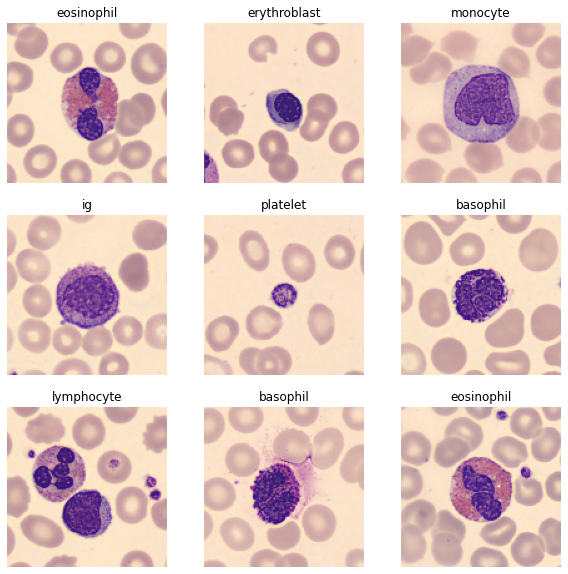

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 1.5. Configure the dataset for performance

In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## 1.6. Data augmentation
When there is no large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as **rotation** and **horizontal flipping**. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# 2. Transfer Learning with MobileNetV2 as a base model

## 2.1. CNN Model construction using Transfer Learning technique 

In [ ]:
# preprocessing as normalization specific to MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
# creation of the base model  MobileNetV2 without last layers 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# freezing wiegts of the base model
base_model.trainable = False

# The new layers for our base model that will be used in the following order
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten=tf.keras.layers.Flatten()
dense_1=tf.keras.layers.Dense(32, activation='relu', name='fc1')
dense_2=tf.keras.layers.Dense(32, activation='relu', name='fc2')
prediction_layer= tf.keras.layers.Dense(8, activation='softmax', name='predictions')


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# connection of the layers
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = flatten(x)
x = dense_1(x)
x = dense_2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name='MobileNetV2')
# our model summary
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                       

# 3. Model Compilation and Training

In [ ]:
# model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model training
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


428/428 [==============================] - 258s 585ms/step - loss: 0.5208 - accuracy: 0.8263 - val_loss: 0.3080 - val_accuracy: 0.8922
Epoch 2/10
428/428 [==============================] - 292s 681ms/step - loss: 0.2499 - accuracy: 0.9152 - val_loss: 0.3004 - val_accuracy: 0.8886
Epoch 3/10
428/428 [==============================] - 265s 618ms/step - loss: 0.2131 - accuracy: 0.9254 - val_loss: 0.2609 - val_accuracy: 0.9082
Epoch 4/10
428/428 [==============================] - 272s 635ms/step - loss: 0.1866 - accuracy: 0.9364 - val_loss: 0.2225 - val_accuracy: 0.9243
Epoch 5/10
428/428 [==============================] - 263s 614ms/step - loss: 0.1835 - accuracy: 0.9355 - val_loss: 0.2141 - val_accuracy: 0.9206
Epoch 6/10
428/428 [==============================] - 261s 609ms/step - loss: 0.1759 - accuracy: 0.9350 - val_loss: 0.2014 - val_accuracy: 0.9304
Epoch 7/10
428/428 [==============================] - 255s 594ms/step - loss: 0.1624 - accuracy: 0.9419 - val_loss: 0.1879 - val_accura

# 4. Model Evalution on Test dataset 
## 4.1. Plotting Learning Curves

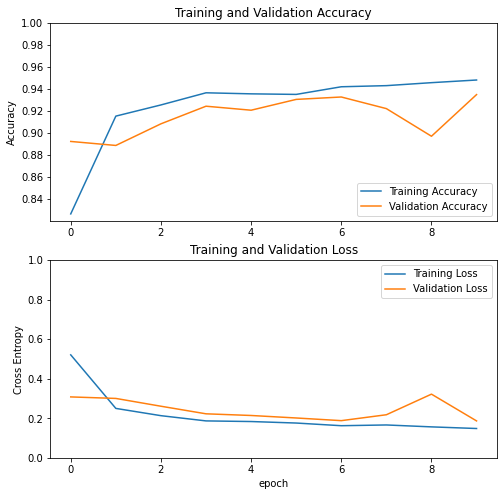

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4.2. Plotting images with predicted labels

Predictions:
 [6 6 3 4 7 6 1 0 2 1 7 2 7 3 6 5 1 1 4 3 6 1 6 3 5 3 3 6 3 7 6 7]
Labels:
 [6 6 3 4 7 6 1 0 2 1 7 2 7 3 6 1 1 1 4 3 6 1 6 3 5 0 3 6 3 7 6 7]


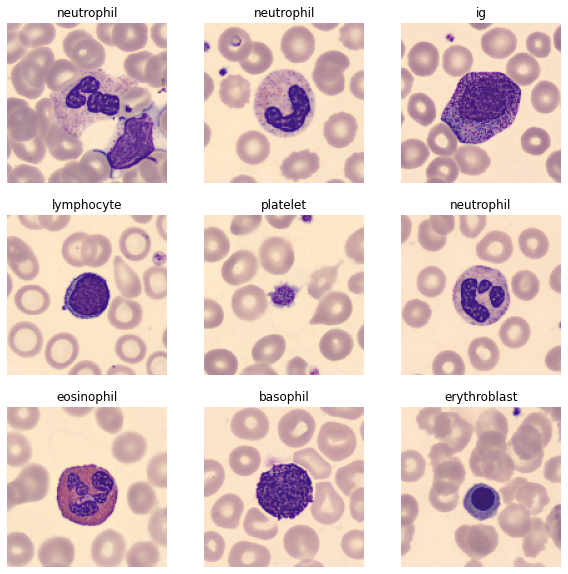

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 4.3. Classification report and Confusion Matrix 

In [ ]:
from sklearn import metrics

print(metrics.classification_report(label_batch,predictions))
conf_matrix=metrics.confusion_matrix(label_batch,predictions)
print(conf_matrix)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         2
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00         2
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         5

    accuracy                           0.94        32
   macro avg       0.92      0.92      0.90        32
weighted avg       0.96      0.94      0.94        32

[[1 0 0 1 0 0 0 0]
 [0 5 0 0 0 1 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 6 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 5]]


# 5. Model Fine-tuning

## 5.1. Choosing number of parameters to tune

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## 5.2. Model Compilation for fune-tuning approach and it's summary

In [ ]:
# model compilation
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [ ]:
# Summary of the Model for Fine-tuning
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                       

In [ ]:
# Number of trainable model parametrs
len(model.trainable_variables)

60

#6. Model training to get optimizied model parameters

In [ ]:
initial_epochs=10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


428/428 [==============================] - 377s 858ms/step - loss: 0.1624 - accuracy: 0.9434 - val_loss: 0.1736 - val_accuracy: 0.9377
Epoch 11/20
428/428 [==============================] - 405s 947ms/step - loss: 0.1308 - accuracy: 0.9530 - val_loss: 0.1644 - val_accuracy: 0.9457
Epoch 12/20
428/428 [==============================] - 398s 930ms/step - loss: 0.1156 - accuracy: 0.9588 - val_loss: 0.1364 - val_accuracy: 0.9523
Epoch 13/20
428/428 [==============================] - 411s 960ms/step - loss: 0.1102 - accuracy: 0.9621 - val_loss: 0.1313 - val_accuracy: 0.9556
Epoch 14/20
428/428 [==============================] - 437s 1s/step - loss: 0.0969 - accuracy: 0.9649 - val_loss: 0.1342 - val_accuracy: 0.9552
Epoch 15/20
428/428 [==============================] - 423s 989ms/step - loss: 0.0921 - accuracy: 0.9681 - val_loss: 0.1105 - val_accuracy: 0.9614
Epoch 16/20
428/428 [==============================] - 452s 1s/step - loss: 0.0853 - accuracy: 0.9707 - val_loss: 0.1041 - val_accura

# 7. Model Evaluation after fine-tuning 
## 7.1. Plotting learning curves

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

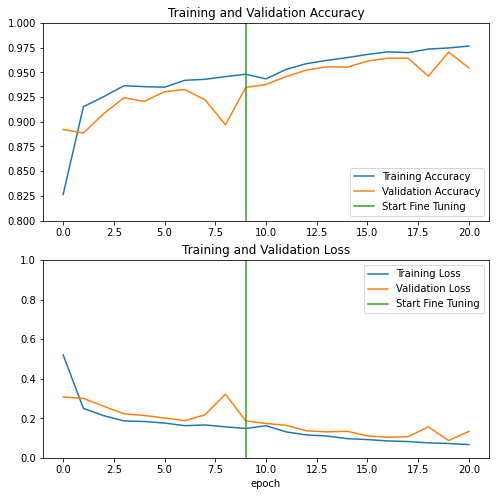

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 7.2. Plotting images with predicted labels

Predictions:
 [0 7 7 6 3 1 3 6 4 3 5 6 5 2 0 1 6 1 1 3 5 6 0 1 5 1 0 5 1 3 1 1]
Labels:
 [0 7 7 6 3 1 3 6 4 3 5 6 5 2 0 1 6 1 1 3 3 6 0 1 5 1 0 5 1 3 1 1]


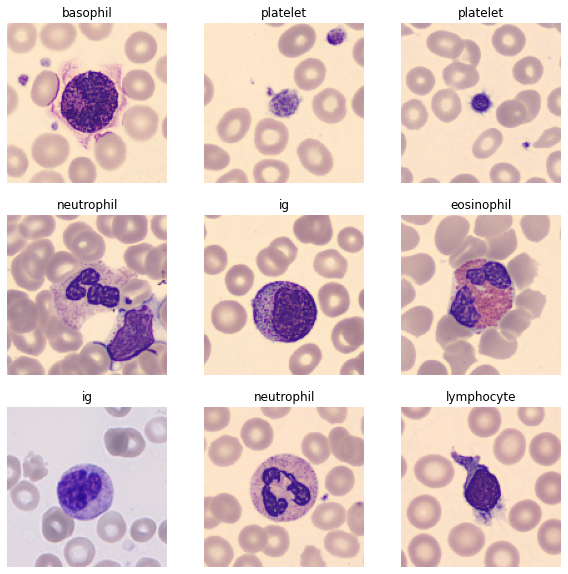

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_ft = model.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions_ft)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions_ft[i]])
  plt.axis("off")



## 7.3. Classification report and Confusion Matrix

In [ ]:
# Classification report and confusion matrix for the 1st BATCH of test_ds

from sklearn import metrics

print(metrics.classification_report(label_batch,predictions_ft))
conf_matrix_ft=metrics.confusion_matrix(label_batch,predictions_ft)
print(conf_matrix_ft)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.97      0.97      0.97        32

[[4 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 5 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 2]]


In [ ]:
# Classification report and confusion matrix for ALL test_ds

L_true=[] # true labels of test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
P=[] # predictions on test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
for element in test_ds.as_numpy_iterator(): 
  image_batch, label_batch = test_ds.as_numpy_iterator().next() # iteration batch by batch
  predictions_ft = model.predict_on_batch(image_batch).argmax(axis=1) # predictions
  L_true.append(label_batch) # addition to the list 
  P.append(predictions_ft)  # addition to the list 

all_L_true = np.concatenate(L_true) # getting a LIST of true labes od test_ds from list of lists
all_P = np.concatenate(P) # # getting a LIST of true labes od test_ds from list of lists

# classification report
print(metrics.classification_report(all_L_true,all_P))

# confusion matrix
conf_matrix_ft_ALL=metrics.confusion_matrix(all_L_true,all_P)
print(conf_matrix_ft_ALL)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       1.00      1.00      1.00       113
           2       1.00      0.95      0.97        37
           3       0.93      0.84      0.89       102
           4       0.91      1.00      0.95        60
           5       0.94      0.96      0.95        76
           6       1.00      0.94      0.97       152
           7       1.00      1.00      1.00        85

    accuracy                           0.96       672
   macro avg       0.95      0.96      0.95       672
weighted avg       0.96      0.96      0.96       672

[[ 47   0   0   0   0   0   0   0]
 [  0 113   0   0   0   0   0   0]
 [  2   0  35   0   0   0   0   0]
 [ 11   0   0  86   3   2   0   0]
 [  0   0   0   0  60   0   0   0]
 [  0   0   0   0   3  73   0   0]
 [  0   0   0   6   0   3 143   0]
 [  0   0   0   0   0   0   0  85]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/TL_MobileNetV2_Barcelona_8112022')